In [1]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd
import torch
import numpy as np
from torch.utils.data import DataLoader

from model_scalar import MixingModelScalar
# from model_vector import MixingModelVector
# from model_tdd import MixingModelTDD
from model_unet import ModelUNet
from model_dummy import ModelDummy
from dataset import MultitrackAudioDataset, no_phase_collate_fn
from medleydb_split import train_songlist, weathervane_music

%load_ext autoreload
%autoreload 2

/home/apelykh/.virtualenvs/pytorch-audio/lib/python3.6/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Torch version: ', torch.__version__)
print('Device: ', device)

print(torch.backends.cudnn.version())
torch.backends.cudnn.benchmark = True

Torch version:  1.4.0
Device:  cuda
7603


In [3]:
base_path = '/media/apelykh/bottomless-pit/datasets/mixing/MedleyDB/Audio'
weights_dir = './weights'
seed = 321
chunk_length = 1

In [4]:
# d = MultitrackAudioDataset(
#     base_path,
#     songlist=weathervane_music,
#     chunk_length=chunk_length,
#     train_val_test_split=(1.0, 0.0, 0.0),
#     mode='train',
#     seed=seed,
#     normalize=False
# )

In [7]:
# d._precompute_features()

[.] Pre-computing features...
0/25: Auctioneer_OurFutureFaces
0/207


/home/apelykh/qmul/msc_project/audio_mixer/dataset.py:183: RuntimeWarning: invalid value encountered in true_divide
  phases = spectrum / magnitudes


30/207
60/207
90/207
120/207
150/207
180/207
1/25: AvaLuna_Waterduct
0/259
30/259
60/259
90/259
120/259
150/259
180/259
210/259
240/259
2/25: Lushlife_ToynbeeSuite
0/628
30/628
60/628
90/628
120/628
150/628
180/628
210/628
240/628
270/628
300/628
330/628
360/628
390/628
420/628
450/628
480/628
510/628
540/628
570/628
600/628
3/25: Grants_PunchDrunk
0/204
30/204
60/204
90/204
120/204
150/204
180/204
4/25: StevenClark_Bounty
0/289
30/289
60/289
90/289
120/289
150/289
180/289
210/289
240/289
270/289
5/25: TheDistricts_Vermont
0/228
30/228
60/228
90/228
120/228
150/228
180/228
210/228
6/25: SecretMountains_HighHorse
0/355
30/355
60/355
90/355
120/355
150/355
180/355
210/355
240/355
270/355
300/355
330/355
7/25: StrandOfOaks_Spacestation
0/243
30/243
60/243
90/243
120/243
150/243
180/243
210/243
240/243
8/25: AClassicEducation_NightOwl
0/171
30/171
60/171
90/171
120/171
150/171
9/25: BigTroubles_Phantom
0/146
30/146
60/146
90/146
120/146
10/25: InvisibleFamiliars_DisturbingWildlife
0/218
30

In [4]:
d_train = MultitrackAudioDataset(
    base_path,
    songlist=weathervane_music,
    chunk_length=chunk_length,
    train_val_test_split=(0.8, 0.2, 0.0),
    mode='train',
    seed=seed,
    normalize=False
)

d_val = MultitrackAudioDataset(
    base_path,
    songlist=weathervane_music,
    chunk_length=chunk_length,
    train_val_test_split=(0.8, 0.2, 0.0),
    mode='val',
    seed=seed,
    normalize=False
)

print('Train: {} tracks, {} chunks'.format(d_train.get_num_songs(), len(d_train)))
print('Val: {} tracks, {} chunks'.format(d_val.get_num_songs(), len(d_val)))

Train: 20 tracks, 5419 chunks
Val: 5 tracks, 1230 chunks


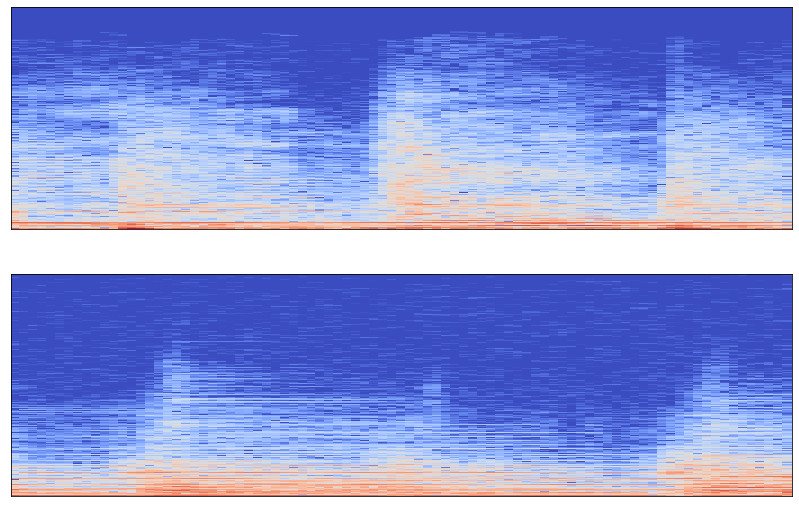

In [12]:
sample = d_train[123]

fig = plt.figure(figsize=(14, 9))

ax1 = plt.subplot(2,1,1)
librosa.display.specshow(sample['gt_features'])

ax2 = plt.subplot(2,1,2, sharex=ax1)
librosa.display.specshow(sample['train_features'][3])
plt.show()

In [5]:
train_loader = DataLoader(d_train, batch_size=128, shuffle=False,
                          num_workers=6, pin_memory=True, drop_last=False, timeout=0,
                          worker_init_fn=None)

val_loader = DataLoader(d_val, batch_size=128, shuffle=False,
                        num_workers=6, pin_memory=True, drop_last=False, timeout=0,
                        worker_init_fn=None)

---
## Defining and training the model

In [6]:
def train_model(model, criterion, optimizer, start_epoch, num_epochs, name='scalar'):
    train_loss = []
    val_loss = []

    for epoch in range(start_epoch, start_epoch + num_epochs):
        running_loss = 0.0

        for i, batch in enumerate(train_loader):
#             print(batch['train_features'].shape)
            optimizer.zero_grad()            
            masked, masks = model(batch['train_features'].to(device))
            loss = criterion(masked, batch['gt_features'].to(device))
            loss.backward()
            optimizer.step()

            each_n_batches = 10
            if i % each_n_batches == each_n_batches - 1:
                print('[%d, %4d] loss: %.3f' % (epoch, i + 1, loss.item()))

            running_loss += loss.item()
            
        avg_epoch_loss = running_loss / len(train_loader)
        print('Epoch {} train loss: {:.4f}'.format(epoch, avg_epoch_loss))
        train_loss.append(avg_epoch_loss)
        
        # ---------------------------------------------------------------
        # validation
        running_val_loss = 0.0

        with torch.no_grad():
            for i, batch in enumerate(val_loader):
                masked, masks = model(batch['train_features'].to(device))
                loss = criterion(masked, batch['gt_features'].to(device))
                running_val_loss += loss.item()

        avg_epoch_val_loss = running_val_loss / len(val_loader)
        print('Epoch {} val loss: {:.4f}'.format(epoch, avg_epoch_val_loss))
        val_loss.append(avg_epoch_val_loss)
        print('-' * 50)

        if epoch % 2 == 0:
            weights_file = os.path.join(weights_dir,
                'mixmodel_{}_1s_{:04d}_{:.4f}.pt'.format(name, epoch, avg_epoch_loss)) 
            torch.save(model.state_dict(), weights_file)
    
    return train_loss, val_loss

In [7]:
model = MixingModelScalar().to(device)

num_trainable_param = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('{} trainable parameters'.format(num_trainable_param))

48908 trainable parameters


In [10]:
# model = ModelUNet(n_channels=4, n_classes=4).to(device)

# num_trainable_param = sum(p.numel() for p in model.parameters() if p.requires_grad)
# print('{} trainable parameters'.format(num_trainable_param))

31053576 trainable parameters


In [8]:
# load weights if we want to continue training
weights = './weights/mixmodel_scalar_1s_0012_115.6854.pt'
model.load_state_dict(torch.load(weights, map_location=device))

<All keys matched successfully>

In [9]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-5)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9)

In [17]:
start_epoch = 0
num_epochs = 20
train_loss, val_loss = train_model(model, criterion, optimizer, start_epoch, num_epochs)

[0,   10] loss: 680.599
[0,   20] loss: 492.444
[0,   30] loss: 803.916
[0,   40] loss: 209.288
Epoch 0 train loss: 982.7848
Epoch 0 val loss: 211.9970
--------------------------------------------------
[1,   10] loss: 253.877
[1,   20] loss: 185.496
[1,   30] loss: 142.776
[1,   40] loss: 172.393
Epoch 1 train loss: 216.8144
Epoch 1 val loss: 153.9221
--------------------------------------------------
[2,   10] loss: 121.918
[2,   20] loss: 251.475
[2,   30] loss: 168.904
[2,   40] loss: 112.378
Epoch 2 train loss: 216.1011
Epoch 2 val loss: 145.9460
--------------------------------------------------
[3,   10] loss: 117.105
[3,   20] loss: 344.921
[3,   30] loss: 125.527
[3,   40] loss: 125.306
Epoch 3 train loss: 193.3104
Epoch 3 val loss: 133.3372
--------------------------------------------------
[4,   10] loss: 133.894
[4,   20] loss: 232.964
[4,   30] loss: 165.397
[4,   40] loss: 111.288
Epoch 4 train loss: 190.8433
Epoch 4 val loss: 148.7921
------------------------------------

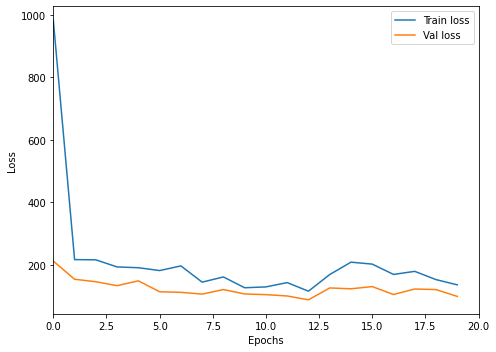

In [18]:
plt.figure(figsize=(7,5))
plt.plot(train_loss, label='Train loss')
plt.plot(val_loss, label='Val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss');
plt.xlim(0, num_epochs)
plt.legend()
plt.tight_layout()
plt.savefig('{}/loss.png'.format(weights_dir))

In [40]:
weights_file = os.path.join(weights_dir, 'mixmodel_scalar_1s_{:04d}_{:.4f}_vermont.pt'.format(20, 0.000))
torch.save(model.state_dict(), weights_file)

In [10]:
from inference_utils import load_tracks, mix_song_istft, mix_song, mix_song_smooth
# https://en.wikipedia.org/wiki/Savitzky%E2%80%93Golay_filter
from scipy.signal import savgol_filter

In [20]:
d_val.songlist

['SecretMountains_HighHorse',
 'SweetLights_YouLetMeDown',
 'HopAlong_SisterCities',
 'CelestialShore_DieForUs',
 'AClassicEducation_NightOwl']

In [11]:
base_dir = '/media/apelykh/bottomless-pit/datasets/mixing/MedleyDB/Audio/'
song_name = 'TheScarletBrand_LesFleursDuMal'
loaded_tracks = load_tracks(base_dir, song_name)

# mixed_song = mix_song_istft(d_val, model, loaded_tracks)
mixed_song, mask_history = mix_song_smooth(d_val, model, loaded_tracks)

librosa.output.write_wav('./results/test.wav', mixed_song, 44100)

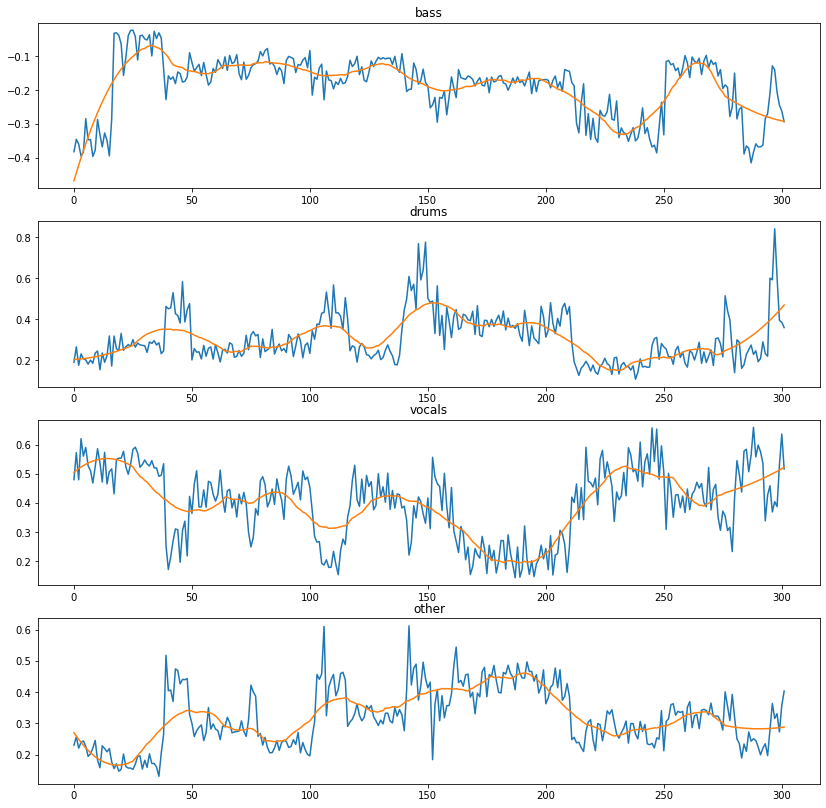

In [12]:
plt.figure(figsize=(14, 14))
for i, track in enumerate(mask_history):
    plt.subplot(4, 1, i + 1)
    plt.title(track)
    
    x_vals = range(len(mask_history['bass']))
    
    plt.plot(x_vals, mask_history[track])
    
    yhat = savgol_filter(mask_history[track], 51, 2)
    plt.plot(x_vals, yhat)

### Mixing manually

In [13]:
tracks = ['bass', 'drums', 'vocals', 'other']
coeffs = [1.0, 1.0, 1.0, 1.0]

sum_track = np.zeros_like(loaded_tracks['mix'])
for i, track in enumerate(tracks):
    sum_track += coeffs[i] * loaded_tracks[track]

# features, _ = d_val.compute_features(sum_track)
# print(np.min(features), np.max(features))
# fig = plt.figure(figsize=(16, 7))
# librosa.display.specshow(features)
# plt.show()

sum_track = librosa.util.normalize(sum_track)

librosa.output.write_wav('./results/sum.wav', sum_track, 44100)

/home/apelykh/qmul/msc_project/audio_mixer/dataset.py:179: RuntimeWarning: invalid value encountered in true_divide
  


-36.186977 -27.32198 43.813023
-36.186977 -27.32198 43.813023


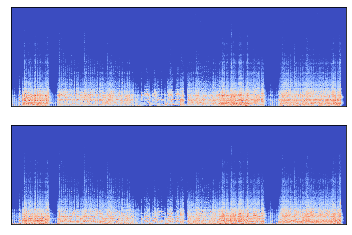

In [16]:
s1, _ = d_val.compute_features(loaded_tracks['other'])
print(np.min(s1), np.mean(s1), np.max(s1))
ax1 = plt.subplot(2,1,1)
librosa.display.specshow(s1)


track = librosa.util.normalize(loaded_tracks['other'])
s2, _ = d_val.compute_features(track)
print(np.min(s2), np.mean(s2), np.max(s2))
ax2 = plt.subplot(2,1,2, sharex=ax1)
librosa.display.specshow(s2)

plt.show()

> Audio normaliztion does not affect spectrogram.

In [39]:
dummy = ModelDummy().to(device)

mixed_song = mix_song_istft(d_val, dummy, loaded_tracks)

librosa.output.write_wav('./test.wav', mixed_song, 44100)

Song 0, chunk 0
Auctioneer_OurFutureFaces
Song 0, chunk 1
Auctioneer_OurFutureFaces
Song 0, chunk 2
Auctioneer_OurFutureFaces
Song 0, chunk 3
Auctioneer_OurFutureFaces
Song 0, chunk 4
Auctioneer_OurFutureFaces
Song 0, chunk 5
Auctioneer_OurFutureFaces
Song 0, chunk 6
Auctioneer_OurFutureFaces
Song 0, chunk 7
Auctioneer_OurFutureFaces
Song 0, chunk 8
Auctioneer_OurFutureFaces
Song 0, chunk 9
Auctioneer_OurFutureFaces
Song 0, chunk 10
Auctioneer_OurFutureFaces
Song 0, chunk 11
Auctioneer_OurFutureFaces
Song 0, chunk 12
Auctioneer_OurFutureFaces
Song 0, chunk 13
Auctioneer_OurFutureFaces
Song 0, chunk 14
Auctioneer_OurFutureFaces
Song 0, chunk 15
Auctioneer_OurFutureFaces
Song 0, chunk 16
Auctioneer_OurFutureFaces
Song 0, chunk 17
Auctioneer_OurFutureFaces
Song 0, chunk 18
Auctioneer_OurFutureFaces
Song 0, chunk 19
Auctioneer_OurFutureFaces
Song 0, chunk 20
Auctioneer_OurFutureFaces
Song 0, chunk 21
Auctioneer_OurFutureFaces
Song 0, chunk 22
Auctioneer_OurFutureFaces
Song 0, chunk 23
Auct

NameError: name 'model' is not defined

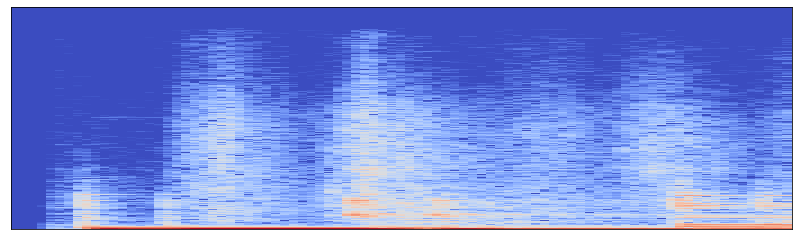

In [6]:
for i, batch in enumerate(train_loader):
    fig = plt.figure(figsize=(14, 9))
    
    ax1 = plt.subplot(2,1,1)
    gt = batch['gt_features'][0].cpu().numpy()
    librosa.display.specshow(gt)
    print(np.min(gt), np.max(gt))
    masked, masks = model(batch['train_features'].to(device))
    masked = masked.detach().cpu().numpy()
    print(np.min(masked), np.max(masked))
    
    ax2 = plt.subplot(2,1,2, sharex=ax1)
    librosa.display.specshow(masked[0])
    plt.show()
    break